# Dark Pool Trade Analysis

This notebook connects to the production database and analyzes dark pool trades.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import pytz
from dotenv import load_dotenv

# Set plot style
#plt.style.use('seaborn')
#"sns.set_palette('deep')
%matplotlib inline

In [ ]:
# Database connection setup
DB_CONFIG = {
    'dbname': 'defaultdb',
    'user': 'doadmin',
    'password': 'AVNS_SrG4Bo3B7uCNEPONkE4',
    'host': 'vvv-trading-db-do-user-2110609-0.i.db.ondigitalocean.com',
    'port': '25060'
}

# Create database URL
DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"

# Create engine with SSL required
engine = create_engine(
    DATABASE_URL,
    connect_args={
        'sslmode': 'require'
    }
)

In [ ]:
# Function to fetch trades for a specific date
def fetch_trades(date_str=None):
    query = """
    SELECT *
    FROM trading.darkpool_trades
    WHERE DATE(executed_at) = %(date)s
    ORDER BY executed_at
    """
    
    if date_str is None:
        date_str = '2025-04-17'  # Default to our test data date
    
    # Pass parameters as a dictionary
    params = {'date': date_str}
    return pd.read_sql_query(query, engine, params=params)

# Fetch trades for April 17th
trades_df = fetch_trades('2025-04-17')
print(f"Fetched {len(trades_df)} trades")
trades_df.head()

# Get Latest Trades Log from Prod DB

In [71]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection setup
DB_CONFIG = {
    'dbname': 'defaultdb',
    'user': 'doadmin',
    'password': 'AVNS_SrG4Bo3B7uCNEPONkE4',
    'host': 'vvv-trading-db-do-user-2110609-0.i.db.ondigitalocean.com',
    'port': '25060'
}

# Create database URL
DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"

# Create engine with SSL required
engine = create_engine(
    DATABASE_URL,
    connect_args={
        'sslmode': 'require'
    }
)

# Query the most recent logs
query = """
SELECT 
    timestamp,
    level,
    message,
    date_trunc('minute', timestamp) as log_minute,
    count(*) over (partition by date_trunc('minute', timestamp)) as logs_per_minute
FROM trading.collector_logs
ORDER BY timestamp DESC
LIMIT 10
"""

logs_df = pd.read_sql_query(query, engine)
print(f"\nMost recent {len(logs_df)} log entries:")
display(logs_df)


Most recent 10 log entries:


,timestamp,level,message,log_minute,logs_per_minute
0,2025-04-24 11:15:02.094537+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 11:15:00+00:00,1
1,2025-04-24 11:10:02.017527+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 11:10:00+00:00,1
2,2025-04-24 11:05:02.906930+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 11:05:00+00:00,1
3,2025-04-24 11:00:02.771662+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 11:00:00+00:00,1
4,2025-04-24 10:55:02.548601+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 10:55:00+00:00,1
5,2025-04-24 10:50:02.683497+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 10:50:00+00:00,1
6,2025-04-24 10:45:02.694596+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 10:45:00+00:00,1
7,2025-04-24 10:40:02.712846+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 10:40:00+00:00,1
8,2025-04-24 10:35:02.680265+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 10:35:00+00:00,1
9,2025-04-24 10:30:02.627972+00:00,INFO,Market closed - Next open: 2025-04-24 09:30 ET,2025-04-24 10:30:00+00:00,1


# Get All Trades and Save as CSV

In [70]:
import pandas as pd
from sqlalchemy import create_engine
import os
from datetime import datetime

# Database connection setup
DB_CONFIG = {
    'dbname': 'defaultdb',
    'user': 'doadmin',
    'password': 'AVNS_SrG4Bo3B7uCNEPONkE4',
    'host': 'vvv-trading-db-do-user-2110609-0.i.db.ondigitalocean.com',
    'port': '25060'
}

# Create database URL
DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"

# Create engine with SSL required
engine = create_engine(
    DATABASE_URL,
    connect_args={
        'sslmode': 'require'
    }
)

# Query all dark pool trades with enhanced metrics
query = """
SELECT 
    t.*,
    date_trunc('hour', t.executed_at) as trade_hour,
    t.price - t.nbbo_bid as price_impact,
    (t.price - t.nbbo_bid) / t.nbbo_bid as price_impact_pct,
    CASE 
        WHEN t.size >= 10000 THEN 'Block Trade'
        WHEN t.premium >= 0.02 THEN 'High Premium'
        ELSE 'Regular'
    END as trade_type,
    count(*) over (partition by t.symbol, date_trunc('hour', t.executed_at)) as trades_per_hour,
    sum(t.size) over (partition by t.symbol, date_trunc('hour', t.executed_at)) as volume_per_hour
FROM trading.darkpool_trades t
ORDER BY t.executed_at DESC
"""

# Fetch trades
print("Fetching all dark pool trades...")
trades_df = pd.read_sql_query(query, engine)

# Convert timestamp columns
trades_df['executed_at'] = pd.to_datetime(trades_df['executed_at'])
trades_df['collection_time'] = pd.to_datetime(trades_df['collection_time'])
trades_df['trade_hour'] = pd.to_datetime(trades_df['trade_hour'])

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Generate filename with current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'data/darkpool_trades_all_{timestamp}.csv'

# Save to CSV
trades_df.to_csv(filename, index=False)
print(f"\nSaved {len(trades_df)} trades to {filename}")

# Print summary statistics
print("\nTrade summary by symbol:")
print(trades_df.groupby('symbol').agg({
    'size': ['count', 'sum', 'mean'],
    'premium': ['mean', 'max'],
    'price_impact_pct': 'mean'
}).round(2))

print("\nDate range of trades:")
print(f"Earliest trade: {trades_df['executed_at'].min()}")
print(f"Latest trade: {trades_df['executed_at'].max()}")
print(f"Total number of trades: {len(trades_df)}")
print(f"Total volume: {trades_df['size'].sum():,.0f}")

Fetching all dark pool trades...

Saved 6322 trades to data/darkpool_trades_all_20250424_130558.csv

Trade summary by symbol:
        size                          premium              price_impact_pct
       count        sum      mean        mean          max             mean
symbol                                                                     
EFA       31   136072.0   4389.42   362303.94   2541109.00              0.0
EZU        3     8579.0   2859.67   154340.12    242112.34              0.0
FXF        7    17835.0   2547.86   274724.15    546250.00              0.0
GLD      735   774146.0   1053.26   327302.92   5736307.50              0.0
QQQ     1781  1508160.0    846.81   375223.71  46063522.10              0.0
SLV       48   400039.0   8334.15   250116.31    953280.00             -0.0
SMH       47   689308.0  14666.13  2890130.33  69609359.54              0.0
SPY     3481  2195701.0    630.77   330850.69  66674595.12              0.0
TLT      118   417334.0   3536.73   30

In [13]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection setup
DB_CONFIG = {
    'dbname': 'defaultdb',
    'user': 'doadmin',
    'password': 'AVNS_SrG4Bo3B7uCNEPONkE4',
    'host': 'vvv-trading-db-do-user-2110609-0.i.db.ondigitalocean.com',
    'port': '25060'
}

# Create database URL
DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"

# Create engine with SSL required
engine = create_engine(
    DATABASE_URL,
    connect_args={
        'sslmode': 'require'
    }
)

# Query recent dark pool trades with enhanced metrics
query = """
SELECT 
    t.*,
    date_trunc('hour', t.executed_at) as trade_hour,
    t.price - t.nbbo_bid as price_impact,
    (t.price - t.nbbo_bid) / t.nbbo_bid as price_impact_pct,
    CASE 
        WHEN t.size >= 10000 THEN 'Block Trade'
        WHEN t.premium >= 0.02 THEN 'High Premium'
        ELSE 'Regular'
    END as trade_type,
    count(*) over (partition by t.symbol, date_trunc('hour', t.executed_at)) as trades_per_hour,
    sum(t.size) over (partition by t.symbol, date_trunc('hour', t.executed_at)) as volume_per_hour
FROM trading.darkpool_trades t
WHERE t.executed_at >= NOW() - INTERVAL '24 hours'
ORDER BY t.executed_at DESC
"""

# Fetch trades
trades_df = pd.read_sql_query(query, engine)

# Convert timestamp columns
trades_df['executed_at'] = pd.to_datetime(trades_df['executed_at'])
trades_df['collection_time'] = pd.to_datetime(trades_df['collection_time'])
trades_df['trade_hour'] = pd.to_datetime(trades_df['trade_hour'])

print(f"\nFetched {len(trades_df)} trades from the last 24 hours")
print("\nTrade summary by symbol:")
display(trades_df.groupby('symbol').agg({
    'size': ['count', 'sum', 'mean'],
    'premium': ['mean', 'max'],
    'price_impact_pct': 'mean'
}).round(2))

print("\nMost recent trades:")
display(trades_df[['symbol', 'size', 'price', 'premium', 'price_impact_pct', 'trade_type', 'executed_at']].head(10))


Fetched 1962 trades from the last 24 hours

Trade summary by symbol:


size                        premium             price_impact_pct
       count       sum      mean       mean         max             mean
symbol                                                                  
EFA        1    2136.0   2136.00  174682.08   174682.08              0.0
EZU        1    2200.0   2200.00  118327.00   118327.00              0.0
GLD      220  239251.0   1087.50  342989.09  5736307.50              0.0
QQQ      569  376105.0    660.99  285213.33  4411500.00              0.0
SLV        7   72947.0  10421.00  310098.20   953280.00              0.0
SMH        6    4791.0    798.50  152464.21   190200.00              0.0
SPY     1152  741215.0    643.42  329754.72  7679250.00              0.0
TLT        4   24027.0   6006.75  521428.97   901036.74              0.0
XLE        2    6361.0   3180.50  255287.20   401150.00              0.0


Most recent trades:


,symbol,size,price,premium,price_impact_pct,trade_type,executed_at
0,QQQ,365.0,441.5963,161182.6495,5.956021e-05,High Premium,2025-04-22 14:05:01+00:00
1,SPY,300.0,522.2446,156673.3800,-1.033988e-05,High Premium,2025-04-22 14:05:00+00:00
2,QQQ,250.0,441.5801,110395.0250,2.264595e-07,High Premium,2025-04-22 14:05:00+00:00
3,QQQ,600.0,441.6100,264966.0000,9.058586e-05,High Premium,2025-04-22 14:05:00+00:00
4,SPY,200.0,522.3100,104462.0000,3.829290e-05,High Premium,2025-04-22 14:04:59+00:00
5,QQQ,328.0,441.5730,144835.9440,6.793940e-06,High Premium,2025-04-22 14:04:59+00:00
6,QQQ,500.0,441.5907,220795.3500,1.585181e-06,High Premium,2025-04-22 14:04:59+00:00
7,QQQ,250.0,441.6004,110400.1000,2.355126e-05,High Premium,2025-04-22 14:04:58+00:00
8,QQQ,400.0,441.5925,176637.0000,2.830744e-05,High Premium,2025-04-22 14:04:58+00:00
9,SPY,200.0,522.3132,104462.6400,4.441977e-05,High Premium,2025-04-22 14:04:58+00:00


In [14]:
def analyze_trade_sizes(trades_df):
    """Analyze trade sizes and premiums"""
    # Calculate basic statistics
    size_stats = trades_df.groupby('symbol').agg({
        'size': ['count', 'sum', 'mean', 'max', 'std'],
        'premium': ['mean', 'max', 'min'],
        'price_impact_pct': ['mean', 'max']
    }).round(2)
    
    # Calculate block trade ratio
    block_trades = trades_df[trades_df['trade_type'] == 'Block Trade']
    block_ratio = block_trades.groupby('symbol').size() / trades_df.groupby('symbol').size()
    size_stats['block_ratio'] = block_ratio.round(3)
    
    return size_stats

size_analysis = analyze_trade_sizes(trades_df)
size_analysis

size                                          premium              \
       count       sum      mean      max      std       mean         max   
symbol                                                                      
EFA        1    2136.0   2136.00   2136.0      NaN  174682.08   174682.08   
EZU        1    2200.0   2200.00   2200.0      NaN  118327.00   118327.00   
GLD      220  239251.0   1087.50  18150.0  1856.65  342989.09  5736307.50   
QQQ      569  376105.0    660.99  10200.0   786.09  285213.33  4411500.00   
SLV        7   72947.0  10421.00  32000.0  9802.76  310098.20   953280.00   
SMH        6    4791.0    798.50   1000.0   126.54  152464.21   190200.00   
SPY     1152  741215.0    643.42  15000.0  1107.47  329754.72  7679250.00   
TLT        4   24027.0   6006.75  10383.0  4736.69  521428.97   901036.74   
XLE        2    6361.0   3180.50   5000.0  2573.16  255287.20   401150.00   

                  price_impact_pct      block_ratio  
              min             mean  max              
symbol                                               
EFA     174682.08              0.0  0.0         NaN  
EZU     118327.00              0.0  0.0         NaN  
GLD     101334.88              0.0  0.0       0.014  
QQQ     100017.52              0.0  0.0       0.002  
SLV     147282.42              0.0  0.0       0.286  
SMH     114942.00              0.0  0.0         NaN  
SPY     100487.73              0.0  0.0       0.005  
TLT     117973.20              0.0  0.0       0.250  
XLE     109424.40              0.0  0.0         NaN

In [15]:
def identify_significant_trades(trades_df):
    """Identify significant trades based on size and premium"""
    # Constants for trade classification
    PRICE_IMPACT_THRESHOLD = 0.01  # 1% price impact threshold
    
    significant_trades = trades_df[
        (trades_df['trade_type'] == 'Block Trade') |
        (trades_df['trade_type'] == 'High Premium') |
        (trades_df['price_impact_pct'] >= PRICE_IMPACT_THRESHOLD)
    ]
    
    return significant_trades

significant_trades = identify_significant_trades(trades_df)
print(f"Found {len(significant_trades)} significant trades")
significant_trades[['symbol', 'size', 'premium', 'price_impact_pct', 'trade_type', 'executed_at']].sort_values('size', ascending=False)

Found 1962 significant trades


,symbol,size,premium,price_impact_pct,trade_type,executed_at
198,SLV,32000.0,9.532800e+05,0.000000,Block Trade,2025-04-22 13:30:00+00:00
501,GLD,18150.0,5.736308e+06,0.000158,Block Trade,2025-04-21 19:04:57+00:00
1354,SPY,15000.0,7.679250e+06,0.000000,Block Trade,2025-04-21 16:09:48+00:00
761,GLD,14274.0,4.500735e+06,0.000032,Block Trade,2025-04-21 18:09:50+00:00
1053,SPY,13500.0,6.886350e+06,0.000039,Block Trade,2025-04-21 17:04:55+00:00
...,...,...,...,...,...,...
1084,SPY,198.0,1.012206e+05,0.000029,High Premium,2025-04-21 16:59:53+00:00
397,SPY,198.0,1.010196e+05,0.000039,High Premium,2025-04-21 19:29:49+00:00
1034,SPY,197.0,1.004877e+05,0.000020,High Premium,2025-04-21 17:09:49+00:00
1225,SPY,197.0,1.009268e+05,0.000037,High Premium,2025-04-21 16:34:45+00:00


In [16]:
def analyze_time_patterns(trades_df):
    """Analyze trading patterns by time of day"""
    time_patterns = trades_df.groupby(['trade_hour', 'symbol']).agg({
        'size': ['sum', 'count', 'mean'],
        'premium': ['mean', 'max'],
        'price_impact_pct': 'mean',
        'trades_per_hour': 'first',
        'volume_per_hour': 'first'
    }).round(2)
    
    return time_patterns

time_patterns = analyze_time_patterns(trades_df)
time_patterns

size                    premium  \
                                       sum count      mean       mean   
trade_hour                symbol                                        
2025-04-21 14:00:00+00:00 GLD      39711.0    47    844.91  266441.62   
                          QQQ      44992.0    75    599.89  259999.46   
                          SPY     112302.0   160    701.89  361917.58   
2025-04-21 15:00:00+00:00 GLD      20382.0    26    783.92  247206.10   
                          QQQ      80360.0    99    811.72  350340.08   
                          SPY     124710.0   178    700.62  359102.80   
2025-04-21 16:00:00+00:00 GLD      37648.0    28   1344.57  423489.44   
                          QQQ      49066.0    69    711.10  306536.17   
                          SPY     138067.0   198    697.31  356960.05   
2025-04-21 17:00:00+00:00 GLD      15980.0    17    940.00  295950.87   
                          QQQ      70538.0    97    727.20  311967.06   
                          SPY     131828.0   167    789.39  402519.15   
2025-04-21 18:00:00+00:00 GLD      36386.0    23   1582.00  499231.63   
                          QQQ      47788.0    84    568.90  243911.79   
                          SPY      78117.0   168    464.98  236810.66   
2025-04-21 19:00:00+00:00 GLD      44185.0    36   1227.36  387575.12   
                          QQQ      52142.0    85    613.44  264085.19   
                          SPY     104930.0   192    546.51  279521.42   
2025-04-22 13:00:00+00:00 EFA       2136.0     1   2136.00  174682.08   
                          EZU       2200.0     1   2200.00  118327.00   
                          GLD      42731.0    40   1068.28  336998.91   
                          QQQ      24507.0    46    532.76  234605.67   
                          SLV      72947.0     7  10421.00  310098.20   
                          SMH       4791.0     6    798.50  152464.21   
                          SPY      43258.0    74    584.57  304317.72   
                          TLT      24027.0     4   6006.75  521428.97   
                          XLE       6361.0     2   3180.50  255287.20   
2025-04-22 14:00:00+00:00 GLD       2228.0     3    742.67  234542.32   
                          QQQ       6712.0    14    479.43  211661.69   
                          SPY       8003.0    15    533.53  278648.86   

                                             price_impact_pct trades_per_hour  \
                                         max             mean           first   
trade_hour                symbol                                                
2025-04-21 14:00:00+00:00 GLD     2610267.00              0.0              47   
                          QQQ      692301.54              0.0              75   
                          SPY     2566525.63              0.0             160   
2025-04-21 15:00:00+00:00 GLD      684840.06              0.0              26   
                          QQQ     4411500.00              0.0              99   
                          SPY     5216380.54              0.0             178   
2025-04-21 16:00:00+00:00 GLD     3566631.77              0.0              28   
                          QQQ     3814881.00              0.0              69   
                          SPY     7679250.00              0.0             198   
2025-04-21 17:00:00+00:00 GLD      683592.08              0.0              17   
                          QQQ     2145850.50              0.0              97   
                          SPY     6886350.00              0.0             167   
2025-04-21 18:00:00+00:00 GLD     4500734.94              0.0              23   
                          QQQ     1284150.30              0.0              84   
                          SPY     1399803.72              0.0             168   
2025-04-21 19:00:00+00:00 GLD     5736307.50              0.0              36   
                          QQQ     1602848.39              0.0              85   
        

In [17]:
def analyze_price_levels(trades_df):
    """Analyze price levels and trade concentration"""
    # Group by symbol and price level
    price_levels = trades_df.groupby(['symbol', 'price']).agg({
        'size': ['sum', 'count'],
        'premium': 'mean',
        'price_impact_pct': 'mean',
        'trade_type': lambda x: (x == 'Block Trade').sum()
    }).round(2)
    
    # Calculate concentration
    price_levels['concentration'] = price_levels[('size', 'sum')] / trades_df.groupby('symbol')['size'].sum()
    
    return price_levels

price_levels = analyze_price_levels(trades_df)
price_levels.sort_values(('concentration', ''), ascending=False).head(20)

size           premium price_impact_pct trade_type  \
                     sum count        mean             mean   <lambda>   
symbol price                                                             
EFA    81.7800    2136.0     1   174682.08              0.0          0   
EZU    53.7850    2200.0     1   118327.00              0.0          0   
XLE    80.2300    5000.0     1   401150.00              0.0          0   
SLV    29.7900   32000.0     1   953280.00              0.0          1   
TLT    86.7800   10383.0     1   901036.74              0.0          1   
       86.8301    9784.0     1   849545.70              0.0          0   
SLV    29.7294   20000.0     2   297294.00              0.0          1   
XLE    80.4000    1361.0     1   109424.40              0.0          0   
SMH    190.2000   1000.0     1   190200.00              0.0          0   
       191.7000    800.0     1   153360.00              0.0          0   
       190.4300    800.0     1   152344.00              0.0          0   
       190.4400    800.0     1   152352.00              0.0          0   
       191.6400    791.0     1   151587.24              0.0          0   
SLV    29.7200   10993.0     2   163355.98              0.0          0   
SMH    191.5700    600.0     1   114942.00              0.0          0   
TLT    86.8641    2500.0     1   217160.25              0.0          0   
GLD    316.0500  18150.0     1  5736307.50              0.0          1   
       315.3100  17161.0     3  1803678.30              0.0          1   
SLV    29.7650    5000.0     1   148825.00              0.0          0   
       29.7300    4954.0     1   147282.42              0.0          0   

                concentration  
                               
symbol price                   
EFA    81.7800       1.000000  
EZU    53.7850       1.000000  
XLE    80.2300       0.786040  
SLV    29.7900       0.438675  
TLT    86.7800       0.432139  
       86.8301       0.407209  
SLV    29.7294       0.274172  
XLE    80.4000       0.213960  
SMH    190.2000      0.208725  
       191.7000      0.166980  
       190.4300      0.166980  
       190.4400      0.166980  
       191.6400      0.165101  
SLV    29.7200       0.150698  
SMH    191.5700      0.125235  
TLT    86.8641       0.104050  
GLD    316.0500      0.075862  
       315.3100      0.071728  
SLV    29.7650       0.068543  
       29.7300       0.067912

In [10]:
def generate_summary_report(trades_df, significant_trades):
    """Generate a summary report of trading activity"""
    report = {
        'Total Trades': len(trades_df),
        'Total Volume': trades_df['size'].sum(),
        'Average Trade Size': trades_df['size'].mean(),
        'Block Trades': len(trades_df[trades_df['trade_type'] == 'Block Trade']),
        'High Premium Trades': len(trades_df[trades_df['trade_type'] == 'High Premium']),
        'Most Active Symbol': trades_df.groupby('symbol')['size'].sum().idxmax(),
        'Largest Block Trade': significant_trades['size'].max() if not significant_trades.empty else 0,
        'Highest Premium': trades_df['premium'].max() * 100,  # Convert to percentage
        'Average Price Impact': trades_df['price_impact_pct'].mean() * 100,  # Convert to percentage
        'Time Range': f"{trades_df['executed_at'].min()} to {trades_df['executed_at'].max()}"
    }
    
    return pd.Series(report)

summary = generate_summary_report(trades_df, significant_trades)
summary

Total Trades                                                         1974
Total Volume                                                    1474598.0
Average Trade Size                                             747.010132
Block Trades                                                           13
High Premium Trades                                                  1961
Most Active Symbol                                                    SPY
Largest Block Trade                                               32000.0
Highest Premium                                               767925000.0
Average Price Impact                                             0.003507
Time Range              2025-04-21 13:59:49+00:00 to 2025-04-22 13:55:...
dtype: object

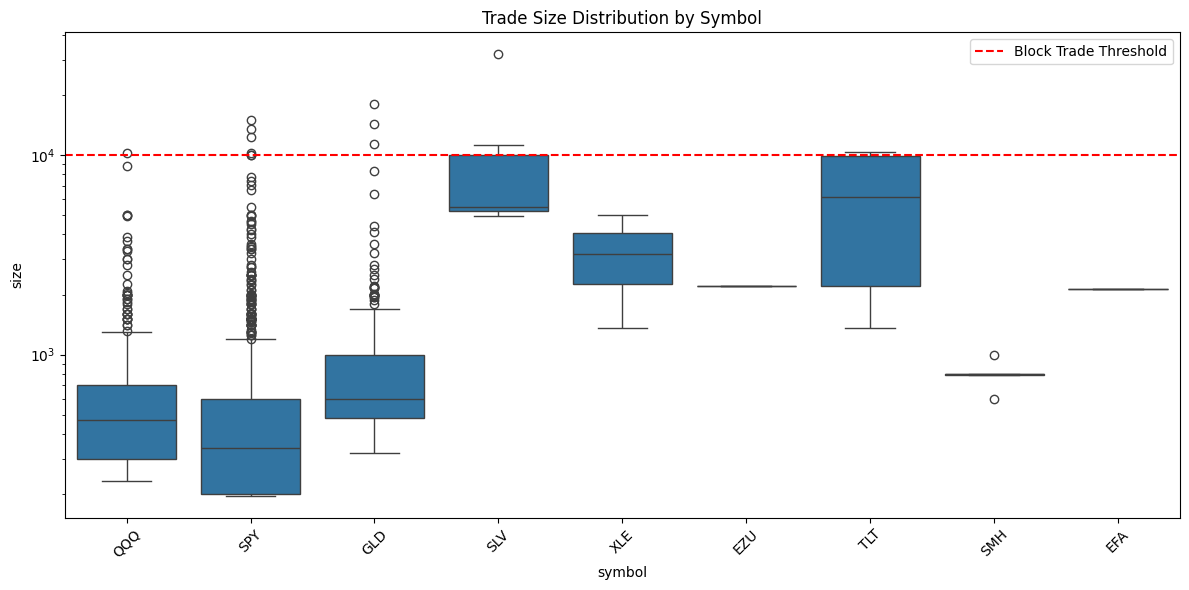

In [18]:
# Constants
BLOCK_SIZE_THRESHOLD = 10000  # Minimum size for block trade
plt.figure(figsize=(12, 6))
sns.boxplot(x='symbol', y='size', data=trades_df)
plt.axhline(y=BLOCK_SIZE_THRESHOLD, color='r', linestyle='--', label='Block Trade Threshold')
plt.title('Trade Size Distribution by Symbol')
plt.xticks(rotation=45)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

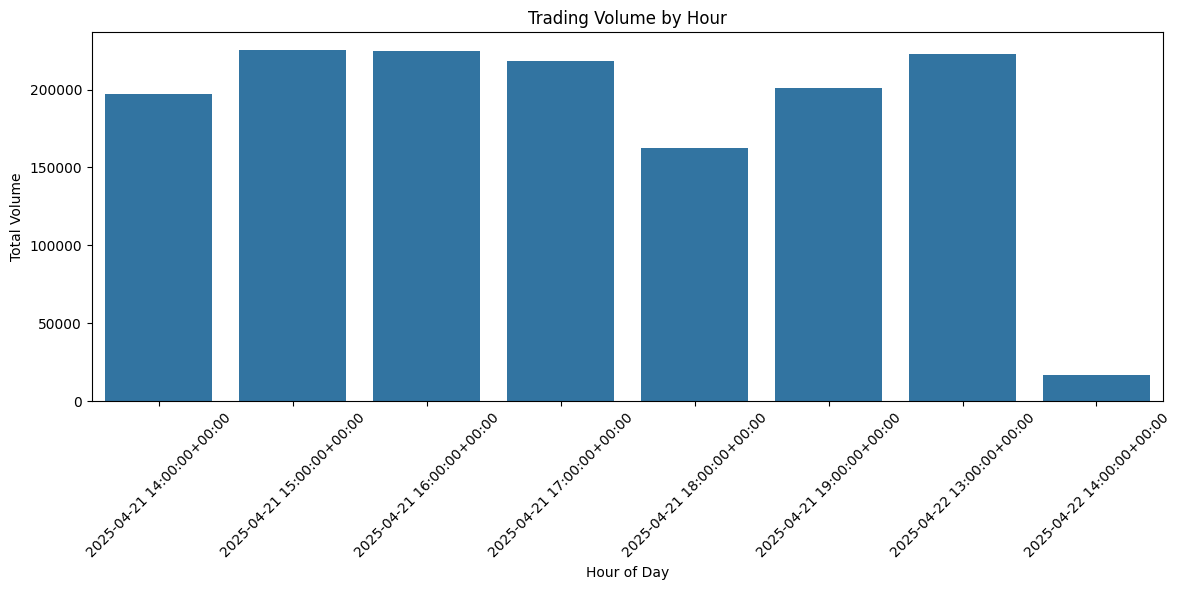

In [19]:
plt.figure(figsize=(12, 6))
hourly_volume = trades_df.groupby('trade_hour')['size'].sum()
sns.barplot(x=hourly_volume.index, y=hourly_volume.values)
plt.title('Trading Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()